#Text Classification (CNN)

**import libraries**

In [202]:
import pandas as pd
import numpy as np
import time
import re

import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Input,MaxPooling1D,Embedding,Flatten
from keras.layers import Concatenate,Dropout,Convolution1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Clean texts**

In [203]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

**Load data (instances)**

In [204]:
def load_data():
    pos_examples = list(open('./data/rt-polarity.pos', encoding='latin-1').readlines())
    pos_examples = [s.strip() for s in pos_examples]
    pos_labels = [1 for _ in pos_examples]
    print('Positive examples -> %s.' % len(pos_examples))
    
    neg_examples = list(open('./data/rt-polarity.neg', encoding='latin-1').readlines())
    neg_examples = [s.strip() for s in neg_examples]
    neg_labels = [0 for _ in neg_examples]
    print('Negative examples -> %s.' % len(neg_examples))
    
    
    x_text = np.concatenate([pos_examples,neg_examples],0)
    x_text = [clean_str(sent) for sent in x_text]
    y = np.concatenate([pos_labels, neg_labels], 0)
    shuffle_indices = np.random.permutation(np.arange(len(x_text)))
    x_text = np.array(x_text)[shuffle_indices]
    y = y[shuffle_indices]
    print('Total examples -> %s.' % len(x_text))
    return x_text, y
        

**Models**

In [219]:
#https://keras.io/api/

def create_model(vocab_size, embedding_dim, num_filters,filter_size,max_sequence_length):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length,name='embed_layer'))
    model.add(layers.Conv1D(filters=num_filters,
                            kernel_size=filter_size,
                            strides=1,
                            padding="valid",
                            activation='relu',
                            name='conv-layer'))
    model.add(layers.MaxPooling1D(pool_size=2,name='pool-size')) #window size
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(10, activation='relu',name='dense_layer'))
    model.add(layers.Dense(1, activation='sigmoid',name='dense_end'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

**Load data**

In [215]:
texts,labels = load_data()
max_sequence_length = np.max([len(txt) for txt in texts])
max_sequence_length

Positive examples -> 5331.
Negative examples -> 5331.
Total examples -> 10662.


266

**Transform input**

In [216]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
x = pad_sequences(sequences, maxlen=max_sequence_length)

x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42)


Found 18758 unique tokens.


**Create model**

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed_layer (Embedding)      (None, 266, 300)          5627700   
_________________________________________________________________
conv-layer (Conv1D)          (None, 264, 128)          115328    
_________________________________________________________________
pool-size (MaxPooling1D)     (None, 132, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16896)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 10)                168970    
_________________________________________________________________
dense_end (Dense)            (None, 1)                 11        
Total params: 5,912,009
Trainable params: 5,912,009
Non-trainable params: 0
___________________________________________

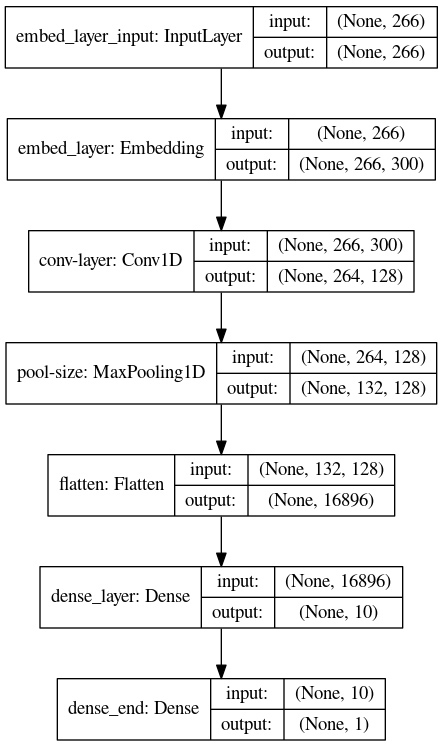

In [221]:
VOCAB_SIZE = len(word_index)+1
EMBED_SIZE = 300
NUM_FILTERS = 128
FILTER_SIZE = 3
model = create_model(vocab_size=VOCAB_SIZE,
                     embedding_dim=EMBED_SIZE,
                     num_filters=NUM_FILTERS,
                     filter_size=FILTER_SIZE,
                     max_sequence_length=max_sequence_length)
model.summary()
plot_model(model,to_file="model.png",show_shapes=True)

**Train Model**

In [170]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
#https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(x_train,
          y_train, 
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_split=0.2,
          shuffle=True)
history_dict = history.history
print(history_dict.keys())

Train on 6823 samples, validate on 1706 samples
Epoch 1/5
6823/6823 [==============================] - 24s 3ms/step - loss: 0.6949 - accuracy: 0.5007 - val_loss: 0.6927 - val_accuracy: 0.5041
Epoch 2/5
6823/6823 [==============================] - 23s 3ms/step - loss: 0.6633 - accuracy: 0.5665 - val_loss: 0.5876 - val_accuracy: 0.6923
Epoch 3/5
6823/6823 [==============================] - 22s 3ms/step - loss: 0.3438 - accuracy: 0.8571 - val_loss: 0.5443 - val_accuracy: 0.7649
Epoch 4/5
6823/6823 [==============================] - 23s 3ms/step - loss: 0.1067 - accuracy: 0.9676 - val_loss: 0.7147 - val_accuracy: 0.7550
Epoch 5/5
6823/6823 [==============================] - 23s 3ms/step - loss: 0.0323 - accuracy: 0.9919 - val_loss: 0.8871 - val_accuracy: 0.7491
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


**Evaluate model**

In [171]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

2133/2133 [==============================] - 4s 2ms/step
Testing Accuracy:  0.7375


**Visualize accuracy**

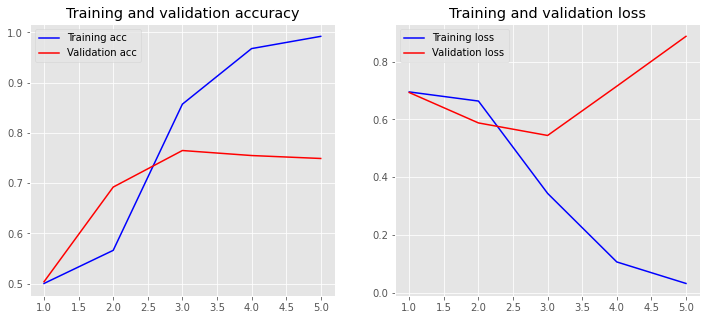

In [173]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

**Confusion matrix**

In [178]:
y_pred = model.predict_classes(x_test).flatten().tolist()
y_pred

[1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,


In [186]:
matrix = confusion_matrix(y_true=y_test,y_pred=y_pred)
matrix

array([[688, 360],
       [200, 885]])

Text(33.0, 0.5, 'Actual')

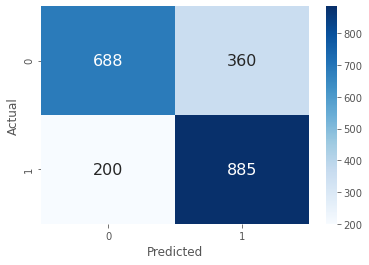

In [195]:
sns.heatmap(matrix, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [200]:
target_names = ['class 0', 'class 1']
print(classification_report(y_true=y_test,y_pred=y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.77      0.66      0.71      1048
     class 1       0.71      0.82      0.76      1085

    accuracy                           0.74      2133
   macro avg       0.74      0.74      0.74      2133
weighted avg       0.74      0.74      0.74      2133

